#Import libraries

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
from pathlib import Path

import io
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from plotly import express as px
from plotly import graph_objects as go
from plotly import figure_factory as ff

from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

#Prepare datasets

In [0]:
# Load datasets
def git_file(file_name):
    return f"https://github.com/EyeBool/YAGAN/blob/master/data/Arabic/{file_name}?raw=true"

x_train_data = pd.read_csv(git_file("csvTrainImages%2013440x1024.csv"), header = None)
x_test_data = pd.read_csv(git_file("csvTestImages%203360x1024.csv"), header = None)

y_train_data = pd.read_csv(git_file("csvTrainLabel%2013440x1.csv"), header = None)
y_test_data = pd.read_csv(git_file("csvTestLabel%203360x1.csv"), header = None)

# Normalize datasets - set range from (0 - 255) to (0.0 - 1.0) 
x_train = (x_train_data.iloc[:,:].values.astype('float32') / 255).reshape([-1, 32, 32, 1])
x_test = (x_test_data.iloc[:,:].values.astype('float32') / 255).reshape([-1, 32, 32, 1])

# Convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train_data - 1, 28)
y_test = tf.keras.utils.to_categorical(y_test_data - 1, 28)

# Print input shape
print("Input shape for images:", x_train.shape)
print("Input shape for labels:", y_train.shape)

Input shape for images: (13440, 32, 32, 1)
Input shape for labels: (13440, 28)


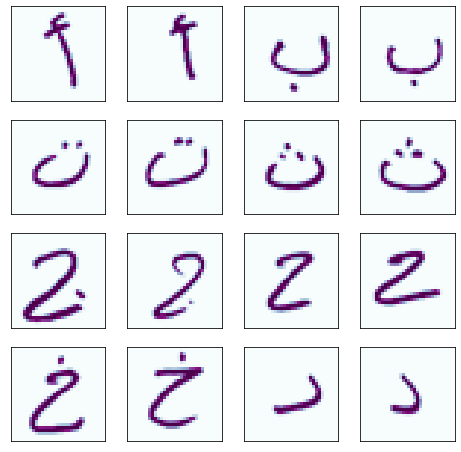

In [0]:
f = px.imshow(np.transpose(x_train[0].reshape((32, 32))))
f.update_layout(width=480, height=480)
f.show()

def visualize_images(df, img_size, number_of_images):
    plt.figure(figsize=(8, 8))
    reshaped_df = df.reshape(df.shape[0], img_size, img_size)
    number_of_rows = number_of_images/4 if number_of_images%4 == 0 else (number_of_images/4) +1
    for i in range(number_of_images):
        plt.subplot(number_of_rows, 4, i+1, xticks=[], yticks=[])
        plt.imshow(np.transpose(reshaped_df[i * 4]), cmap='BuPu')

visualize_images(x_train, 32, 16)  # 32, image size, 16, num of image to show 

#Prepare training images 

In [0]:
# Split training images into fitting set and fit validation set  

x_fit = x_train[1000:]
y_fit = y_train[1000:]

x_fit_val = x_train[:1000]
y_fit_val = y_train[:1000]

print('Total images for fitting   :', len(x_fit))
print('Total images for validating: ', len(x_fit_val))

Total images for fitting   : 12440
Total images for validating:  1000


In [0]:
# Use Keras ImageDataGenerator to generate to image data with real-time data augmentation.

datagen = ImageDataGenerator(  
        rotation_range=10,  
        zoom_range = 0.1,
        width_shift_range=0.1,  
        height_shift_range=0.1, 
        horizontal_flip=False,  
        vertical_flip=False)  

datagen.fit(x_train)

#Create and train neural network models

In [0]:
# Set input shape
input_shape = (x_train.shape[1], x_train.shape[1], x_train.shape[3])
print(input_shape)

(32, 32, 1)


In [0]:
# Create function to compile and train model

def compile_and_train(nn_model):
    model: Sequential = nn_model

    model.compile(
        optimizer=Adam(amsgrad=True),
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )


    learning_rate = ReduceLROnPlateau(
        monitor='val_categorical_accuracy', 
        patience=3, 
        verbose=1, 
        factor=9/10, 
        cooldown=2,
        min_delta=0.0005,
        min_lr=0.0005
        )
    
    history = model.fit_generator(
        datagen.flow(x_fit, y_fit, batch_size = 64),
        epochs = 30, 
        callbacks=[learning_rate],
        steps_per_epoch=x_train.shape[0] // 64,
        validation_data = (x_fit_val, y_fit_val),
        verbose=2
        )

In [0]:
def evaluate(nn_model):
    return nn_model.evaluate(x_test, y_test)

In [0]:
# Create function to evaluate model and plot chart

def evaluate_and_plot(nn_model, title):
    model = nn_model
    acc = evaluate(model)[1]*100

    cols =["loss", "categorical_accuracy", "val_loss", "val_categorical_accuracy", "lr"]
    col_names = ["Loss", "Categorical accuracy", "Validation loss", "Validation categorical accuracy", "learning rate (x 1000)"]
    names = {cols[i]: col_names[i] for i in range(len(cols))}

    x = pd.DataFrame(model.history.history, columns=cols)

    fig = go.Figure()

    for col in cols:
        fig.add_trace(go.Scatter(x=x.index, y= [i * 1000 for i in x[col]] if col is 'lr' else x[col], mode='lines', name=names[col]))
    fig.update_layout(title=f"{title} | Accuracy: {acc:.3f}%",
                    xaxis_title="Epoch",
                    yaxis_title="Rate",
    )
    return fig

In [0]:
# Build convolutional neural network (CNN) model

def build_CNN_model():
    return Sequential([
        # Input layer 
        Input(shape=input_shape),

        # Convolutional layer block 1
        Conv2D(64, 5, padding='same', activation="relu"),
        Conv2D(64, 5, activation="relu"),
        MaxPooling2D(2),
     
        # Convolutional layer block 2
        Conv2D(128, 3, padding='same', activation="relu"),
        Conv2D(128, 3, activation="relu"),
        MaxPooling2D(2),

        # Convolutional layer block 3
        Conv2D(256, 3, padding='same', activation="relu"),
        Conv2D(256, 3, activation="relu"),
        MaxPooling2D(2),

        #Dense layer
        Flatten(),
        Dense(1024, activation="relu"), 

        # Output layer
        Flatten(),
        Dense(28, activation="softmax"), 
    ])

CNN_model = build_CNN_model()

CNN_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 32, 32, 64)        1664      
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 28, 28, 64)        102464    
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 12, 12, 128)       147584    
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 6, 6, 256)       

In [0]:
compile_and_train(CNN_model)

Epoch 1/30
Epoch 1/30
1000/210 - 1s - loss: 0.8738 - categorical_accuracy: 0.6320
210/210 - 8s - loss: 1.7641 - categorical_accuracy: 0.4206 - val_loss: 1.1193 - val_categorical_accuracy: 0.6320
Epoch 2/30
Epoch 1/30
1000/210 - 0s - loss: 0.5041 - categorical_accuracy: 0.7970
210/210 - 6s - loss: 0.6025 - categorical_accuracy: 0.7907 - val_loss: 0.6487 - val_categorical_accuracy: 0.7970
Epoch 3/30
Epoch 1/30
1000/210 - 0s - loss: 0.3188 - categorical_accuracy: 0.8720
210/210 - 6s - loss: 0.3578 - categorical_accuracy: 0.8821 - val_loss: 0.3873 - val_categorical_accuracy: 0.8720
Epoch 4/30
Epoch 1/30
1000/210 - 0s - loss: 0.2124 - categorical_accuracy: 0.8950
210/210 - 6s - loss: 0.2607 - categorical_accuracy: 0.9172 - val_loss: 0.3165 - val_categorical_accuracy: 0.8950
Epoch 5/30
Epoch 1/30
1000/210 - 0s - loss: 0.2205 - categorical_accuracy: 0.9190
210/210 - 6s - loss: 0.2082 - categorical_accuracy: 0.9333 - val_loss: 0.3062 - val_categorical_accuracy: 0.9190
Epoch 6/30
Epoch 1/30
100

In [0]:
CNN_fig = evaluate_and_plot(CNN_model, "Training CNN")
CNN_fig.show()

In [0]:
# Build convolutional neural network (CNN) model with Dropout

def build_CNN_dropout_model():
    return Sequential([
        # Input layer 
        Input(shape=input_shape),

        # Convolutional layer block 1
        Conv2D(64, 5, padding='same', activation="relu"),
        Conv2D(64, 5, activation="relu"),
        MaxPooling2D(2),
        Dropout(0.25),
     
        # Convolutional layer block 2
        Conv2D(128, 3, padding='same', activation="relu"),
        Conv2D(128, 3, activation="relu"),
        MaxPooling2D(2),
        Dropout(0.25),

        # Convolutional layer block 3
        Conv2D(256, 3, padding='same', activation="relu"),
        Conv2D(256, 3, activation="relu"),
        MaxPooling2D(2),
        Dropout(0.25),

        #Dense layer
        Flatten(),
        Dense(1024, activation="relu"), 
        Dropout(0.25),

        # Output layer
        Flatten(),
        Dense(28, activation="softmax"), 
    ])

CNN_dropout_model = build_CNN_dropout_model()

CNN_dropout_model.summary()


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 32, 32, 64)        1664      
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 28, 28, 64)        102464    
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 12, 12, 128)       147584    
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 6, 6, 128)       

In [0]:
compile_and_train(CNN_dropout_model)

Epoch 1/30
Epoch 1/30
1000/210 - 1s - loss: 1.3151 - categorical_accuracy: 0.5030
210/210 - 9s - loss: 2.4133 - categorical_accuracy: 0.2249 - val_loss: 1.4135 - val_categorical_accuracy: 0.5030
Epoch 2/30
Epoch 1/30
1000/210 - 0s - loss: 0.6930 - categorical_accuracy: 0.6830
210/210 - 6s - loss: 0.8985 - categorical_accuracy: 0.6804 - val_loss: 0.8739 - val_categorical_accuracy: 0.6830
Epoch 3/30
Epoch 1/30
1000/210 - 0s - loss: 0.3161 - categorical_accuracy: 0.8680
210/210 - 6s - loss: 0.5275 - categorical_accuracy: 0.8159 - val_loss: 0.4326 - val_categorical_accuracy: 0.8680
Epoch 4/30
Epoch 1/30
1000/210 - 0s - loss: 0.2292 - categorical_accuracy: 0.8970
210/210 - 6s - loss: 0.3473 - categorical_accuracy: 0.8844 - val_loss: 0.3415 - val_categorical_accuracy: 0.8970
Epoch 5/30
Epoch 1/30
1000/210 - 0s - loss: 0.1769 - categorical_accuracy: 0.9280
210/210 - 6s - loss: 0.2767 - categorical_accuracy: 0.9152 - val_loss: 0.2556 - val_categorical_accuracy: 0.9280
Epoch 6/30
Epoch 1/30
100

In [0]:
CNN_dropout_fig = evaluate_and_plot(CNN_dropout_model,"Training CNN (with Dropout)")
CNN_dropout_fig.show()

In [0]:
# Build long short term memory (LSTM) neural network model

def build_LSTM_model():
    return Sequential([
        # Input layer 
        Input(shape=input_shape),

        # LSTM layer
        Flatten(),
        Reshape((2, 512)),
        LSTM(280),
        Dropout(0.25),

        # Output layer
        Flatten(),
        Dense(28, activation="softmax"), 
    ])

LSTM_model = build_LSTM_model()

LSTM_model.summary()


Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_35 (Flatten)         (None, 1024)              0         
_________________________________________________________________
reshape_9 (Reshape)          (None, 2, 512)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 280)               888160    
_________________________________________________________________
dropout_25 (Dropout)         (None, 280)               0         
_________________________________________________________________
flatten_36 (Flatten)         (None, 280)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 28)                7868      
Total params: 896,028
Trainable params: 896,028
Non-trainable params: 0
_______________________________________________

In [0]:
compile_and_train(LSTM_model)

Epoch 1/30
Epoch 1/30
1000/210 - 1s - loss: 0.4891 - categorical_accuracy: 0.7810
210/210 - 11s - loss: 0.5477 - categorical_accuracy: 0.8091 - val_loss: 0.6096 - val_categorical_accuracy: 0.7810
Epoch 2/30
Epoch 1/30
1000/210 - 0s - loss: 0.4543 - categorical_accuracy: 0.7910
210/210 - 6s - loss: 0.5382 - categorical_accuracy: 0.8158 - val_loss: 0.5896 - val_categorical_accuracy: 0.7910
Epoch 3/30
Epoch 1/30
1000/210 - 0s - loss: 0.4191 - categorical_accuracy: 0.8050
210/210 - 6s - loss: 0.5214 - categorical_accuracy: 0.8253 - val_loss: 0.5549 - val_categorical_accuracy: 0.8050
Epoch 4/30
Epoch 1/30
1000/210 - 0s - loss: 0.4440 - categorical_accuracy: 0.8060
210/210 - 6s - loss: 0.5246 - categorical_accuracy: 0.8225 - val_loss: 0.5572 - val_categorical_accuracy: 0.8060
Epoch 5/30
Epoch 1/30
1000/210 - 0s - loss: 0.4168 - categorical_accuracy: 0.8090
210/210 - 6s - loss: 0.5063 - categorical_accuracy: 0.8259 - val_loss: 0.5491 - val_categorical_accuracy: 0.8090
Epoch 6/30
Epoch 1/30
10

In [0]:
LSTM_fig = evaluate_and_plot(LSTM_model, "Training LSTM (100 cells)")
LSTM_fig.show()

In [0]:
LSTM_fig = evaluate_and_plot(LSTM_model, "Training LSTM (200 cells)")
LSTM_fig.show()

In [0]:
LSTM_fig = evaluate_and_plot(LSTM_model, "Training LSTM (300 cells)")
LSTM_fig.show()

In [0]:
LSTM_fig = evaluate_and_plot(LSTM_model, "Training LSTM (400 cells)")
LSTM_fig.show()

In [0]:
LSTM_fig = evaluate_and_plot(LSTM_model, "Training LSTM (500 cells)")
LSTM_fig.show()

In [0]:
LSTM_fig = evaluate_and_plot(LSTM_model, "Training LSTM (1000 cells)")
LSTM_fig.show()

In [0]:
# Build hybrid neural network model

def build_hybrid_model():
    return Sequential([
        # Input layer 
        Input(shape=input_shape),

        # Convolutional layer block 1
        Conv2D(64, 5, padding='same', activation="relu"),
        Conv2D(64, 5, activation="relu"),
        MaxPooling2D(2),
        Dropout(0.25),
     
        # Convolutional layer block 2
        Conv2D(128, 3, padding='same', activation="relu"),
        Conv2D(128, 3, activation="relu"),
        MaxPooling2D(2),
        Dropout(0.25),

        # Convolutional layer block 3
        Conv2D(256, 3, padding='same', activation="relu"),
        Conv2D(256, 3, activation="relu"),
        MaxPooling2D(2),
        Dropout(0.25),

        #Dense layer
        Flatten(),
        Dense(1024, activation="relu"), 
        Dropout(0.25),

        # LSTM layer
        Flatten(),
        Reshape((2, 512)),
        LSTM(300, return_sequences=True),
        Dropout(0.25),

        # Output layer
        Flatten(),
        Dense(28, activation="softmax"), 
    ])


In [0]:
hybrid_model = build_hybrid_model()
compile_and_train(hybrid_model)
while(evaluate(hybrid_model)[1]*100) < 98.2:
    model = hybrid_model = build_hybrid_model()
    # hybrid_model.summary()
    compile_and_train(hybrid_model)

Epoch 1/30
Epoch 1/30
1000/210 - 1s - loss: 1.7477 - categorical_accuracy: 0.3240
210/210 - 10s - loss: 2.6472 - categorical_accuracy: 0.1572 - val_loss: 1.9305 - val_categorical_accuracy: 0.3240
Epoch 2/30
Epoch 1/30
1000/210 - 0s - loss: 1.1111 - categorical_accuracy: 0.5420
210/210 - 6s - loss: 1.3069 - categorical_accuracy: 0.4749 - val_loss: 1.2176 - val_categorical_accuracy: 0.5420
Epoch 3/30
Epoch 1/30
1000/210 - 0s - loss: 0.5044 - categorical_accuracy: 0.7390
210/210 - 6s - loss: 0.7645 - categorical_accuracy: 0.6928 - val_loss: 0.6760 - val_categorical_accuracy: 0.7390
Epoch 4/30
Epoch 1/30
1000/210 - 0s - loss: 0.5505 - categorical_accuracy: 0.7540
210/210 - 6s - loss: 0.5148 - categorical_accuracy: 0.8071 - val_loss: 0.7408 - val_categorical_accuracy: 0.7540
Epoch 5/30
Epoch 1/30
1000/210 - 0s - loss: 0.3171 - categorical_accuracy: 0.8450
210/210 - 6s - loss: 0.3797 - categorical_accuracy: 0.8660 - val_loss: 0.4779 - val_categorical_accuracy: 0.8450
Epoch 6/30
Epoch 1/30
10

In [0]:
hybrid_fig = evaluate_and_plot(hybrid_model, "Training CNN + LSTM(300) (with Dropout)")
hybrid_fig.show()

3360/3360 [==============================] - 1s 195us/sample - loss: 0.0736 - categorical_accuracy: 0.9830


#Result and evaluation

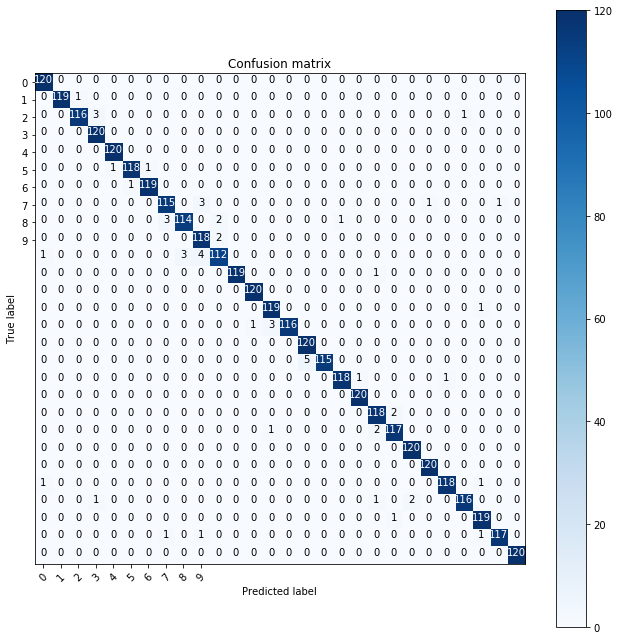

In [0]:
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
plt.figure(num='digit',figsize=(9,9))
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

In [0]:
Y_pred = model.predict(x_test)
Y_true = np.argmax(y_test,axis = 1) 

Y_pred_classes = np.argmax(Y_pred,axis = 1) 

tp = (Y_pred_classes - Y_true == 0)
fp = (Y_pred_classes - Y_true != 0)

fn = (Y_pred_classes - Y_true != 1)
tn = (Y_pred_classes - Y_true == 1)

print("True positive  :", list(tp).count(True))
print("False positive :", list(fp).count(True))
print("True negative  :", list(tn).count(True))
print("False negative :", list(fn).count(True))


True positive  : 3303
False positive : 57
True negative  : 10
False negative : 3350


<Figure size 1800x1800 with 0 Axes>

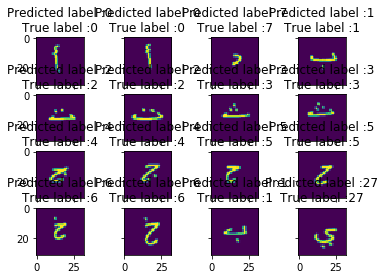

In [0]:
#Display some error results 
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = x_test[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 4
    ncols = 4
    plt.figure(num='digit',figsize=(25,25))
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]

            im_err = np.transpose(img_errors[error].reshape((32, 32)))
            ax[row,col].imshow(im_err)
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-16:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

#Save trained neural network model

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
from datetime import datetime
# Save neural network structure
model_structure = model.to_yaml()
f = Path(f"/content/drive/My Drive/Colab Notebooks/models/CNN_LSTM_model_structure{datetime.now()}{acc:.3f}.yaml")
f.write_text(model_structure)

# Save neural network's trained weights
model.save_weights(f"/content/drive/My Drive/Colab Notebooks/models/CNN_LSTM_model_weights{datetime.now()}{acc:.3f}.h5")
print(f"Done saving {f}")